## Data acquisition

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

from tqdm import tqdm
%matplotlib inline

<Figure size 432x288 with 0 Axes>

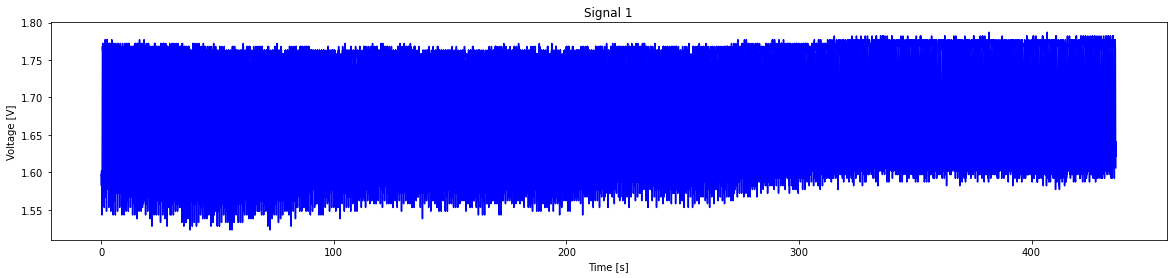

<Figure size 432x288 with 0 Axes>

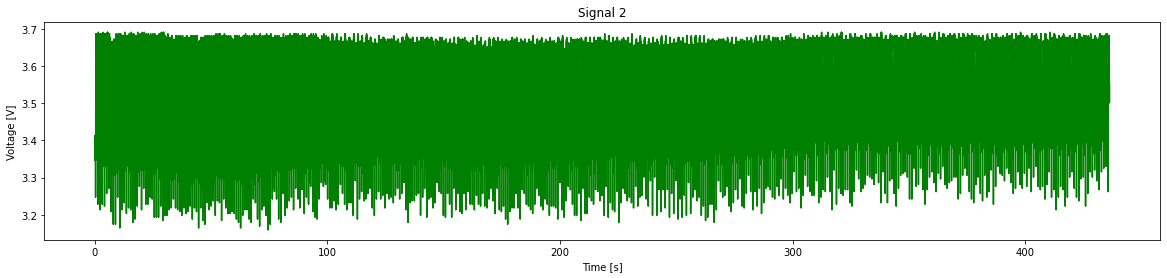

In [5]:
#************************************
folder   = '../19-11/'
filename = 'B-ol15-aq15-pause10.csv'
#************************************


sig1=[]
sig2=[]
t = []
i=0

folder.rstrip('/') + '/'

# Data acquisition 
with open(folder + filename) as data:
    for sig in csv.reader(data, delimiter='	'):
        #print(sig)
        sig[0] = sig[0].replace('.','').replace(',','.')
        sig[1] = sig[1].replace('.','').replace(',','.')
        sig[2] = sig[2].replace('.','').replace(',','.')
        #print(sig)
        sig1.append(float(sig[0]))
        sig2.append(float(sig[1]))
        t.append(float(sig[2]))
sig1 = np.array(sig1)
sig1 = sig1[0:-1]
sig2 = np.array(sig2)
sig2 = sig2[0:-1]
t = np.array(t)
t = t[0:-1]        

# Plot signal 1
plt.figure()
plt.figure(figsize=(20,4))
plt.title('Signal 1')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.plot(t, sig1, color='blue')
plt.show()

# Plot signal 2
plt.figure()
plt.figure(figsize=(20,4))
plt.title('Signal 2')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.plot(t, sig2, color='green')
plt.show()


## Fourier transformation


In [9]:
max_freq  = 1       # lower cut-off frequency
min_freq  = 3000    # higher cut-off frequency

In [10]:
# The function does the Fast Fourier Transformation (FFT) and filters the signal keeping the frequency in [min_freq; max_freq]. 
# Then the function returns the anti-transformed filtered signal.

def FFT_cropping(signal, min_freq, max_freq):
    
    # FFT of signal 
    F_sig = np.fft.fft(signal)                            

    # FFT signal plot
    fig, axes = plt.subplots(nrows=1, ncols=1)
    axes.set_xlabel('Frequency')
    axes.plot(F_sig, label='FFT')
    axes.set_ylim(0,200)

    # Signal filtering
    F_sig_crop       = np.zeros(len(F_sig))
    F_sig[:max_freq] = F_sig_crop[:max_freq]     # Set to 0 F_sig above max_freq
    F_sig[min_freq:] = F_sig_crop[min_freq:]     # Set to 0 F_sig under min_freq

    # FFT signal filtered plot
    axes.plot(F_sig, label='FFT cropped')
    axes.legend()

    # Anti-FFT of F_sig
    sig_high = np.fft.ifft(F_sig).real
    
    return sig_high

### Signal 1 

E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


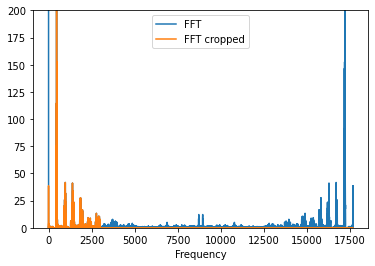

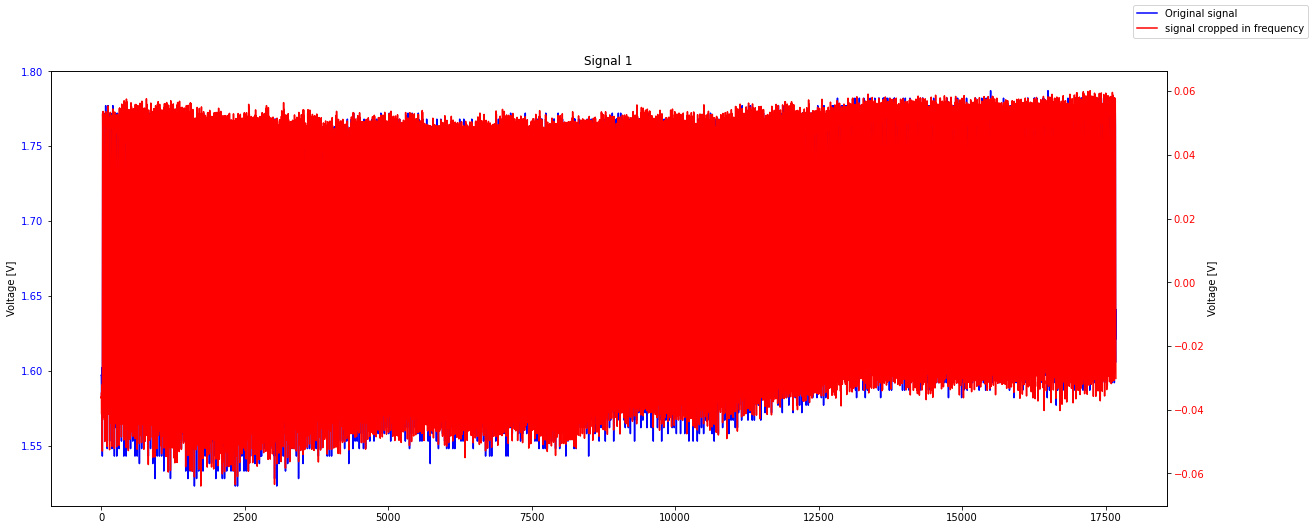

In [11]:
# FFT transform filtering
sig1_high = FFT_cropping(sig1, min_freq, max_freq)

x_min = 0       # signal plot x min.
x_max = 20000   # signal plot x max.
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'blue'
ax1.set_title('Signal 1')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig1[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig1_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


### Signal 2 

E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


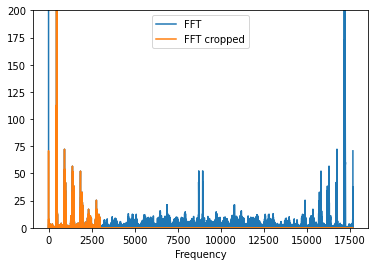

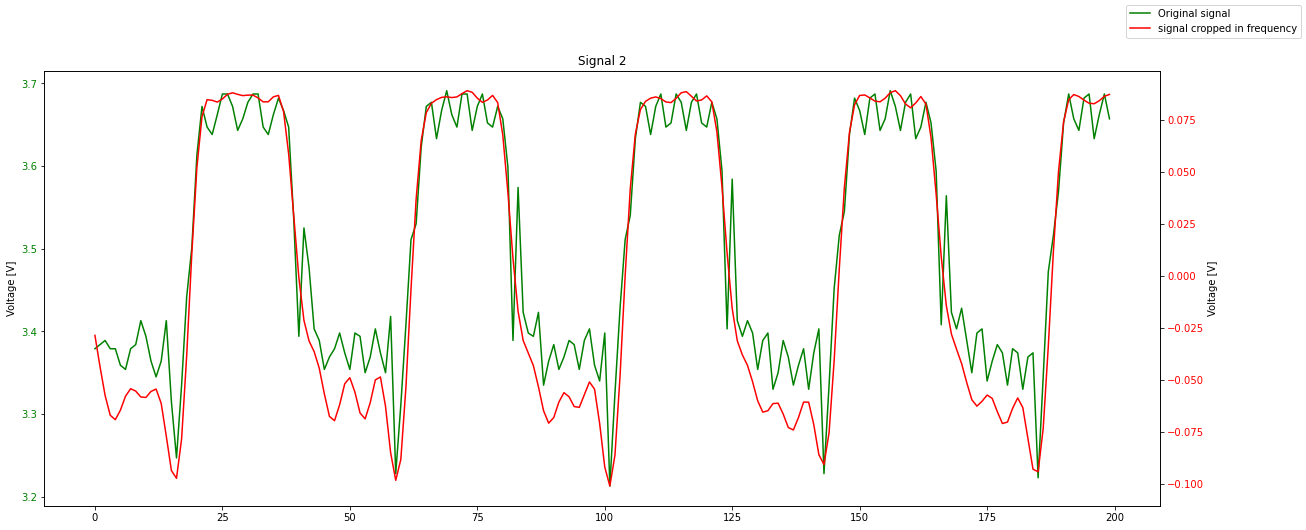

In [12]:
# FFT transform filtering
sig2_high = FFT_cropping(sig2, min_freq, max_freq)

x_min = 0    # Plot x min.
x_max = 200  # Plot x max. 
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'green'
ax1.set_title('Signal 2')
ax1.set_xlabel('')
ax1.set_ylabel('Voltage [V]')
ax1.plot(sig2[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor= color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()                                 
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(sig2_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()

## Thresholds computing

In [13]:
def thr_searcher(Data, nbins, color):
    
    # Histogram definition
    freq,bins,p = plt.hist(Data, nbins, color=color)
    x = 0.5 *(bins[:-1] + bins[1:])
    plt.clf() # Clear figure
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    from lmfit.models import GaussianModel

    #Cicle changing center1 position if condition (center1+2*sigma1 < center2-2*sigma2) is not fulfilled
    for i in range(1,6):    

        # Gaussian 1
        gauss1 = GaussianModel(prefix='g1_')
        pars   = gauss1.make_params(center=x[0]+i*(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq)/20)
        
        # Gaussian 2
        gauss2 = GaussianModel(prefix='g2_')
        pars.update(gauss2.make_params())

        # Gaussian 1 parameters
        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)

        # Gaussian 2 parameters
        pars['g2_center'].set(value=x[-1]*0.98)
        pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
        pars['g2_amplitude'].set(value=max(freq)/20, min=10)

        mod  = gauss1 + gauss2
        init = mod.eval(pars, x=x)
        out  = mod.fit(freq, pars, x=x)

        # Plot histo
        axes[0].hist(Data, nbins, color=color)
        axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel("Voltage [V]")
        axes[0].set_ylabel("Number of events") 

        # Searching the best fit
        center2 = out.best_values.get('g2_center')
        sigma2  = out.best_values.get('g2_sigma')
        center1 = out.best_values.get('g1_center')
        sigma1  = out.best_values.get('g1_sigma')

        if center1+2*sigma1 < center2-2*sigma2:
            max_freq1 = max(freq[x<center1+sigma1])
            x_max1    = x[np.argmax(freq[x<center1+2*sigma1])]
            max_freq2 = max(freq[x>center2-sigma2])
            a         = x > center2-sigma2
            freq2     = np.zeros(len(freq))
            for i in range(len(a)): 
                if a[i]==True: freq2[i]=freq[i]
            x_max2 = x[np.argmax(freq2)]
            break
        else: print('trying again')
     
    # Thresholds computing
    thr_low  = x_max1 + 2*sigma1
    thr_high = x_max2 - 2*sigma1
    print('thr_low  = ', thr_low,' \t[V] \nthr_high = ', thr_high, ' \t[V]')
    
    # Signal plot
    axes[1].plot(t, Data, color)
    axes[1].plot(thr_high*np.ones(len(t)), color='red')
    axes[1].plot(thr_low*np.ones(len(t)), color='red')
    plt.xlim((0,t[len(t)-1]))
    axes[1].set_title("Signal with thresholds")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_ylabel("Voltage [V]") 
    
    return thr_low, thr_high

### Signal 1

thr_low  =  -0.021514749329912805  	[V] 
thr_high =  0.032551277653905836  	[V]


<Figure size 432x288 with 0 Axes>

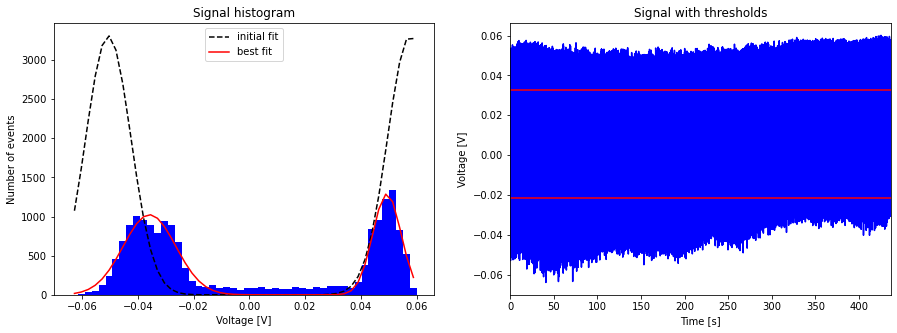

In [14]:
thr_low_1, thr_high_1 = thr_searcher(sig1_high, 50, 'blue')

### Signal 2

thr_low  =  -0.023170367098060293  	[V] 
thr_high =  0.037163128331158576  	[V]


<Figure size 432x288 with 0 Axes>

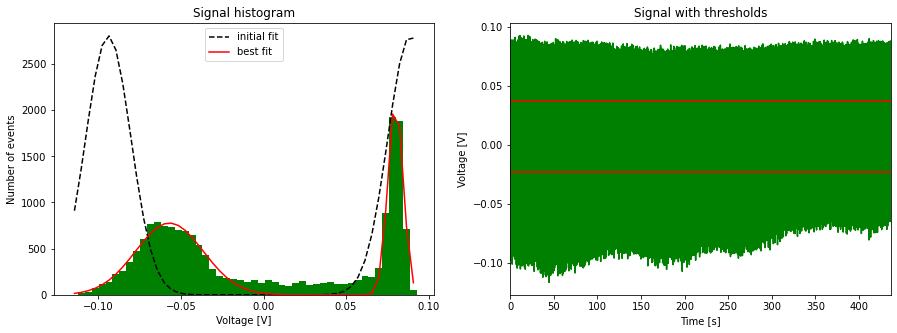

In [15]:
thr_low_2, thr_high_2 = thr_searcher(sig2_high, 50, 'green')

## Drops detection

In [16]:
#definisco una goccia da quando il segnale sale sopra la soglia alta a quando scende sotto la soglia bassa
def drop_det(time, data, thr_low, thr_high, ymin, ymax, xrange):
    
    # Drops edges computing
    bool_high  = data > thr_high
    bool_low   = data < thr_low
    drop_start = [0]
    drop_end   = [1]
   
    # Detection 
    for i in range(len(data)-1):
        
        if bool_high[i]==False and bool_low[i+1]==False and bool_high[i+1]==True:
            if drop_start[-1] < drop_end[-1] and i > drop_end[-1]:
                drop_start.append(i)
                
        elif bool_low[i]==False and bool_low[i+1]==True and bool_high[i+1]==False:
            if drop_start[-1] > drop_end[-1] and i > drop_start[-1]:
                drop_end.append(i)
 
    # Number acquisition -> time [s] conversion
    drop_start = time[drop_start]
    drop_end   = time[drop_end]
    
    # Selection
    drop_start = drop_start[1:]
    drop_end   = drop_end[1:]
    
    # Cropping
    if len(drop_start) > len(drop_end):
        drop_start = drop_start[:-1]
    
    # Plotting 
    for j in range(int (time[-1]/xrange)):
        plt.figure()
        plt.figure(figsize=(20,4))
        for i in range(len(drop_end)):
        
            plt.vlines(drop_start[i], ymin, ymax, color='green')
            plt.vlines(drop_end[i], ymin, ymax, color='red')

        plt.plot(time, data)
        plt.ylabel("Voltage [V]")
        plt.xlabel("Time [s]")
        plt.xlim(j*xrange,(j+1)*xrange)
        plt.ylim(ymin, ymax)
        plt.show()
        
    return drop_start, drop_end
    
    

### Signal 1

<Figure size 432x288 with 0 Axes>

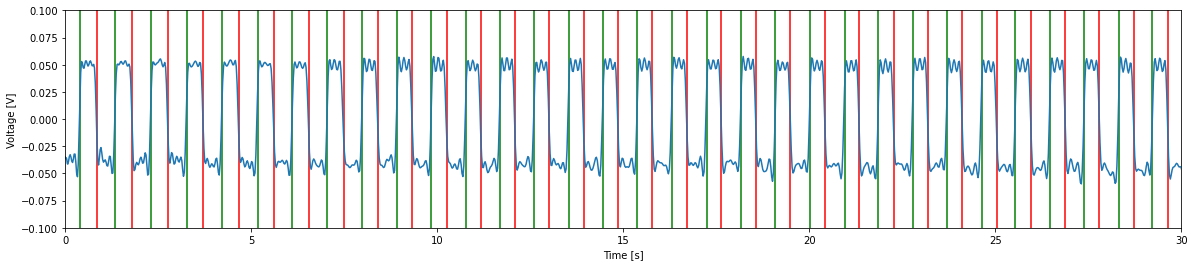

<Figure size 432x288 with 0 Axes>

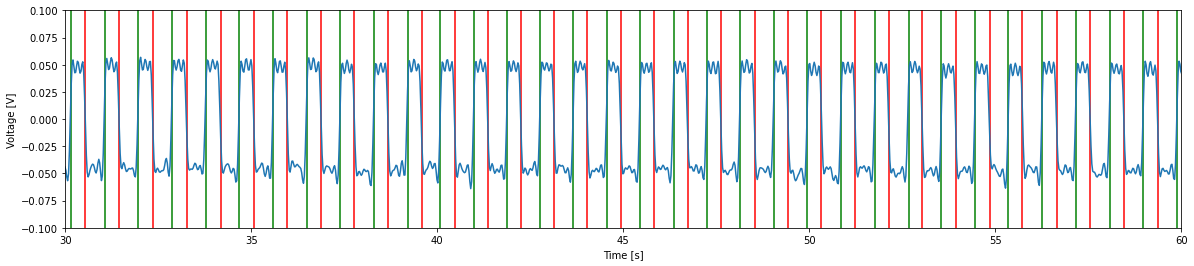

<Figure size 432x288 with 0 Axes>

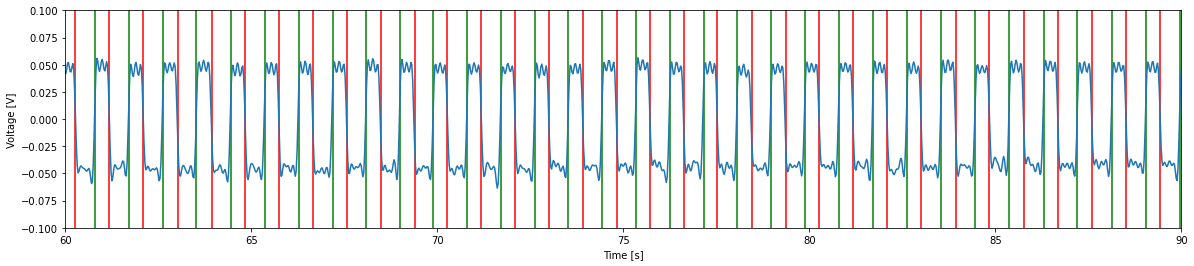

<Figure size 432x288 with 0 Axes>

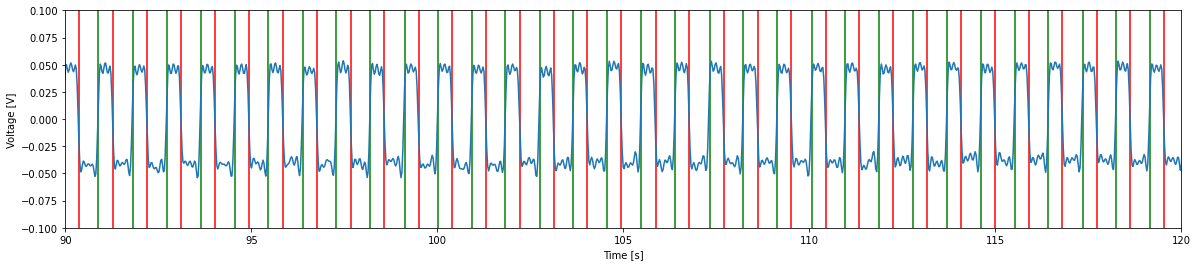

<Figure size 432x288 with 0 Axes>

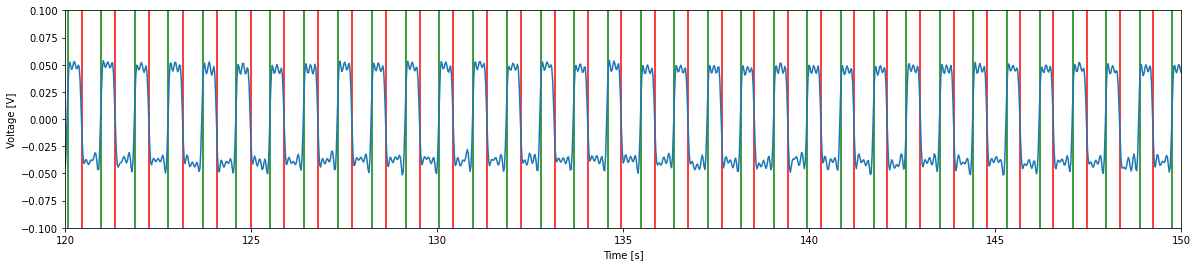

<Figure size 432x288 with 0 Axes>

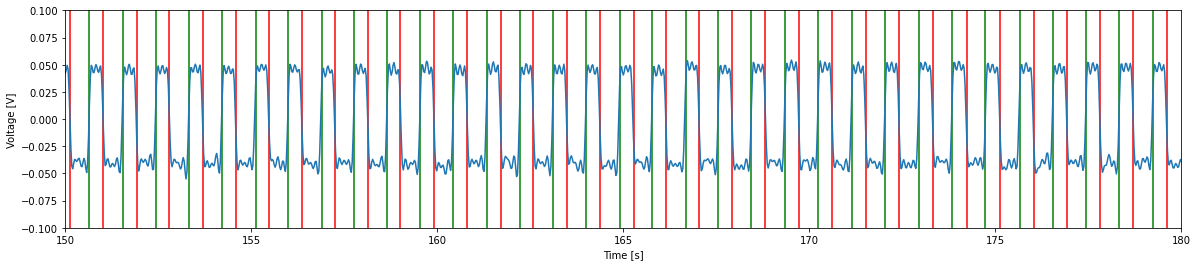

<Figure size 432x288 with 0 Axes>

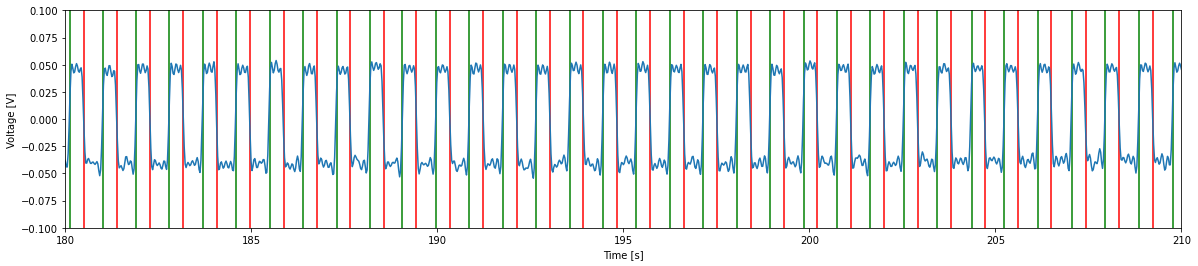

<Figure size 432x288 with 0 Axes>

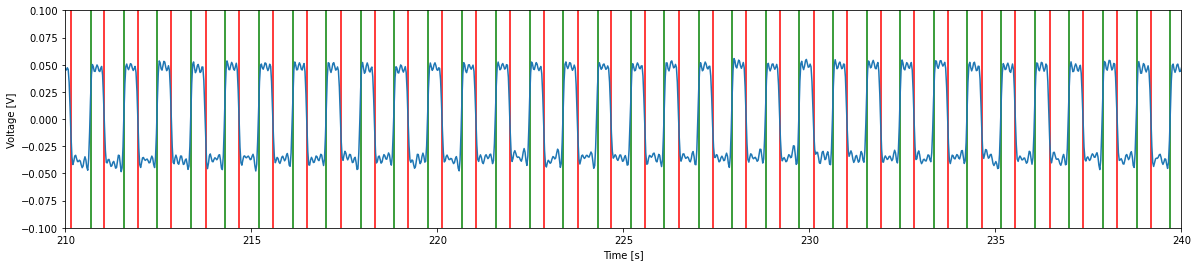

<Figure size 432x288 with 0 Axes>

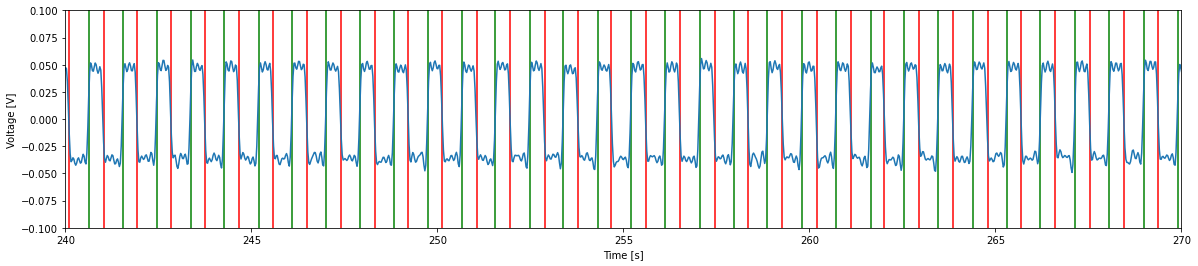

<Figure size 432x288 with 0 Axes>

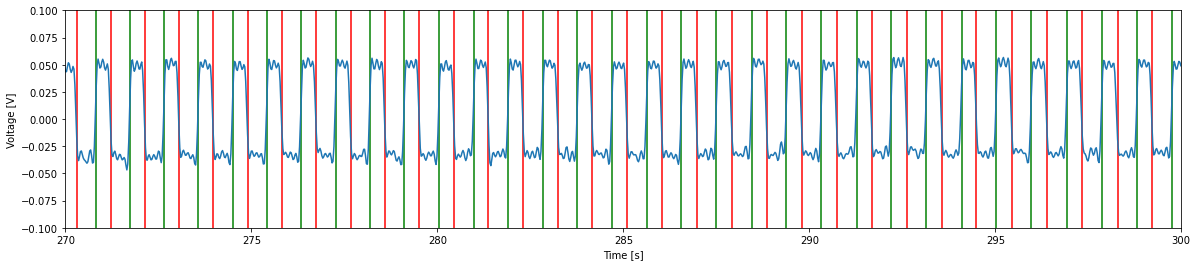

<Figure size 432x288 with 0 Axes>

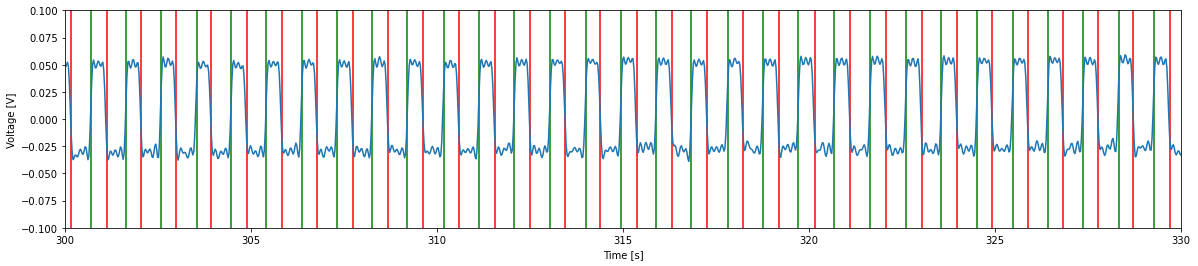

<Figure size 432x288 with 0 Axes>

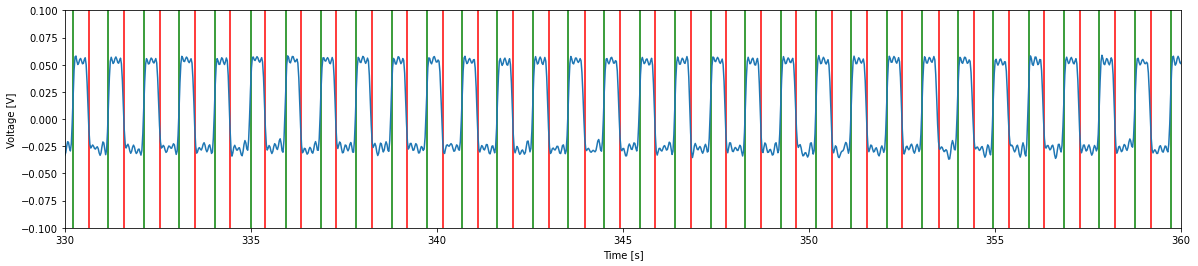

<Figure size 432x288 with 0 Axes>

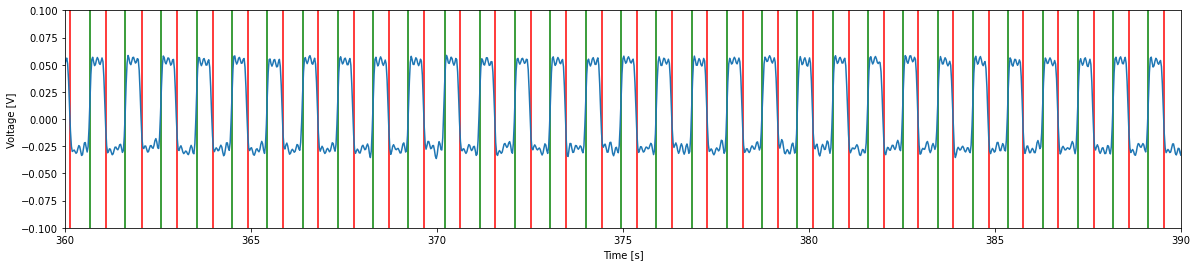

<Figure size 432x288 with 0 Axes>

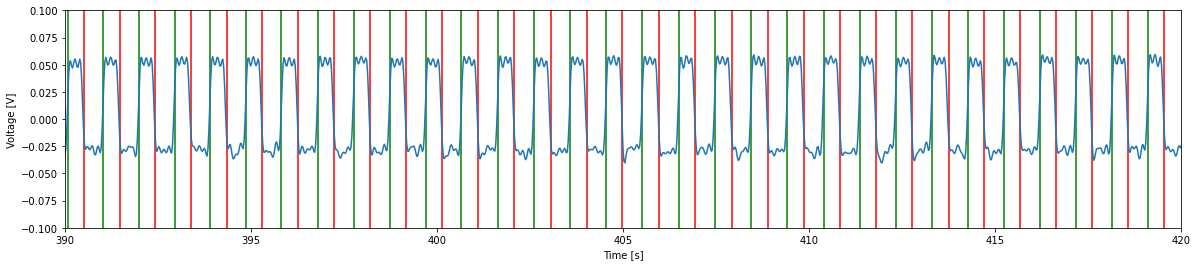

In [20]:
ymin         = -0.1         # plot y min. [V]
ymax         = 0.1          # plot y max. [V]
xrange       = 300          # single plot x range [s]
drop_start_1, drop_end_1 = drop_det(t, sig1_high, thr_low_1, thr_high_1, ymin, ymax, xrange)

### Signal 2

<Figure size 432x288 with 0 Axes>

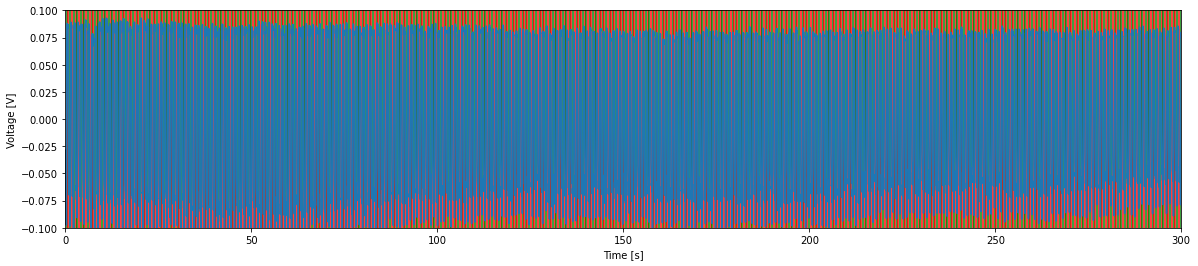

In [21]:
ymin         = -0.1           # plot y min. [V]
ymax         = 0.1            # plot y max. [V]
xrange       = 300            # single plot x range [s]
drop_start_2, drop_end_2 = drop_det(t, sig2_high, thr_low_2, thr_high_2, ymin, ymax, xrange)

## Velocity estimation

In [23]:
# spannometric estimation of the time interval between the drops, knowing the pumps fluxes and capillary size

#********************************************************
radius  = 0.3  # capillary radius [mm]
sep     = 50   # spearation between the two sensors [mm]
flux_ol = 15   # oil flux   [uL/min] = [mm3/min]
flux_aq = 15   # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]
dt = sep/v                      # time interval between two following drops [s]

print('v  = ', v,'\t[mm/s] \ndt = ', dt, '\t[s]')

v  =  7.073553026306459 	[mm/s] 
dt =  7.068583470577035 	[s]


### Drops time interval histograms  

(array([ 24.,   0.,   0.,   0.,   0.,  95.,   9.,   0.,   0.,  47., 206.,
          1.,   0.,   0.,  51.,  36.,   0.,   0.,   0.,   1.]),
 array([0.448 , 0.4531, 0.4582, 0.4633, 0.4684, 0.4735, 0.4786, 0.4837,
        0.4888, 0.4939, 0.499 , 0.5041, 0.5092, 0.5143, 0.5194, 0.5245,
        0.5296, 0.5347, 0.5398, 0.5449, 0.55  ]),
 <a list of 20 Patch objects>)

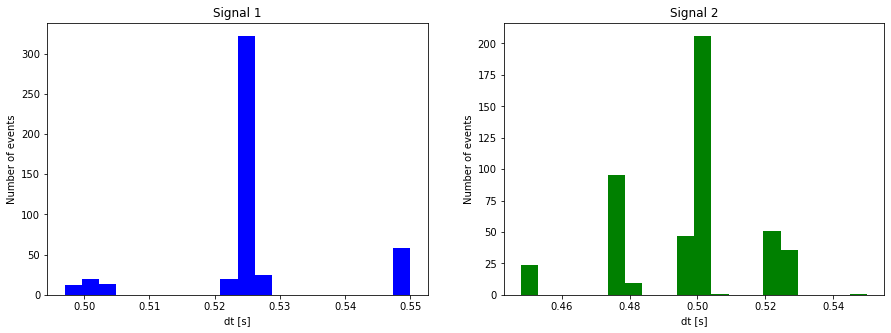

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
nbins = 20

# Plot signal 1
axes[0].set_title("Signal 1")
axes[0].set_xlabel("dt [s]")
axes[0].set_ylabel("Number of events") 
axes[0].hist(drop_start_1[1:] - drop_end_1[:-1], nbins, color='blue')

# Plot signal 2
axes[1].set_title("Signal 2")
axes[1].set_xlabel("dt [s]")
axes[1].set_ylabel("Number of events") 
axes[1].hist(drop_start_2[1:] - drop_end_2[:-1], nbins, color='green')


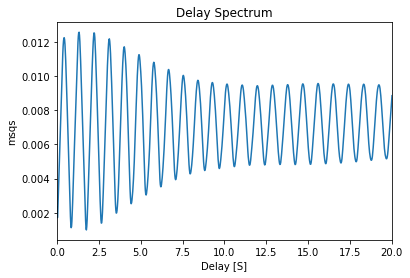

In [33]:
delay_idxs = np.arange(2000)

msqs = []

for idx in delay_idxs:
    sig1_cut = sig1_high[:len(sig2_high) - idx][0:1000]
    sig2_cut = sig2_high[idx:][0:1000]
    
    msqs.append(np.mean((sig1_cut - sig2_cut)**2))

# Plot    
plt.figure()
plt.title('Delay Spectrum')
plt.xlabel('Delay [S]')
plt.ylabel('msqs')
plt.xlim(0,20)
plt.plot(t[delay_idxs],msqs)

In [34]:
# Gaussian formula

q = np.sqrt(2*np.pi)

def gaus(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

In [35]:
# Gaussian smoothing functions 

# Signal 1
@np.vectorize
def sig1_smooth(t, sigma, delta):
    s = 0.
    for t_s in drop_end_1:
        if (t - t_s)**2 < (delta*sigma)**2:
            s += gaus(t,t_s,sigma)
        if t_s - t > (delta+1)*sigma:
            break
            
    return s

# Signal 2
@np.vectorize
def sig2_smooth(t, sigma, delta):
    s = 0.
    for t_s in drop_end_2:
        if (t - t_s)**2 < (delta*sigma)**2:
            s += gaus(t,t_s,sigma)
        if t_s - t > (delta+1)*sigma:
            break
            
    return s

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:28<00:00,  7.00it/s]


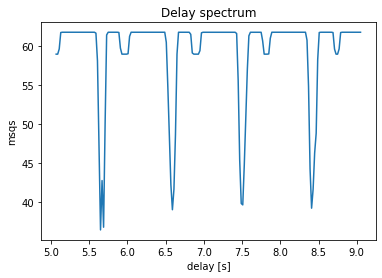

In [36]:
# Estimation of the following drops delay by the msqs computing of the difference of the sig.2 delayed and the sig.1 

#*********************************************************************************************
# Signal gaussian smoothing
sigma       = 0.01   # stdev
delta       = 2      # range = delta*stdev
# Delay
delta_delay = 2      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
step_delay  = 0.02   # step of evaluated delays [s]
# Time
start_time  = 10     # scanning signal starting time [s]
stop_time   = 20     # scanning signal stopping time [s]
step_time   = 0.005  # scanning signal step time [s]
#*********************************************************************************************

start_delay = dt - delta_delay                                # initial evaluated delay [s]
stop_delay  = dt + delta_delay                                # final evaluated delay [s]
time_delays = np.arange(start_delay, stop_delay, step_delay)  # vector of evaluated delays [s]
ts          = np.arange(start_time,  stop_time,  step_time)   # vector of scanned times [s]
msqs        = []                                              # stdev between sig.1 and sig.2 delayed 

# Computing
for time_delay in tqdm(time_delays):
    
    sig1_t = sig1_smooth(ts, sigma, delta)
    sig2_t = sig2_smooth(ts + time_delay, sigma, delta)
    msqs.append(np.mean((sig2_t - sig1_t)**2))

# Plot
plt.figure()
plt.title('Delay spectrum')
plt.xlabel("delay [s]")
plt.ylabel("msqs")
plt.plot(time_delays,msqs)

In [28]:
# save the delay spectrum to csv file
save_name = filename.rsplit('.',1)[0] + '_delay.csv'
data      = np.stack([time_delays,msqs],axis=0)
df        = pd.DataFrame(data=data.T,columns=['time_delay','msqs'])
df.to_csv(save_name)

t =  0.304 	[s]


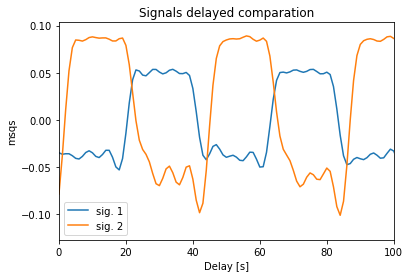

In [28]:
# Manual delay comparation
idx = 17
sig1_cut = sig1_high[:len(sig2_high) - idx]
sig2_cut = sig2_high[idx:]
print('t = ', t[idx], '\t[s]')

# Plot
plt.figure()
plt.title('Signals delayed comparation')
plt.xlabel("Delay [s]")
plt.ylabel("msqs")
plt.xlim(0, 100)
plt.plot(sig1_cut, label='sig. 1')
plt.plot(sig2_cut, label='sig. 2')
plt.legend()